# California august temperature anomaly

*How anomalous was the August 2020 average temperature?*

![California Temperature August 2020](../../graphs/California_anomaly.png)


In this first section, we load required packages and modules

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
##import packages
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cdsapi 


#for rank calculation
# import bottleneck

In [3]:
os.chdir(os.path.abspath('../../'))

## Load ERA5

We have retrieved netcdf files of global monthly 2m temperature and 2m dewpoint temperature for each year over 1979-2020. 

We load all files with xarray `open_mfdataset`. 

In [4]:
ERA5 = xr.open_mfdataset('../California_example/ERA5/ERA5_????.nc',combine='by_coords') ## open the data
ERA5#

,Array,Chunk
Bytes,522.65 kB,12.44 kB
Shape,"(42, 51, 61)","(1, 51, 61)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,522.65 kB,12.44 kB
Shape,"(42, 51, 61)","(1, 51, 61)"
Count,126 Tasks,42 Chunks
Type,float32,numpy.ndarray


## Retrieve the land-sea mask

We retrieve the land-sea mask for ERA5 from CDS.

In [5]:
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'land_sea_mask',
        'grid': [1.0, 1.0], 
        'year': '1979',
        'month': '01',
        'time': '00:00',
    },
    '../California_example/ERA_landsea_mask.nc')

2021-08-12 10:14:27,929 INFO Welcome to the CDS
2021-08-12 10:14:27,931 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2021-08-12 10:14:28,432 INFO Request is completed
2021-08-12 10:14:28,433 INFO Downloading https://download-0011.copernicus-climate.eu/cache-compute-0011/cache/data5/adaptor.mars.internal-1628605177.1251855-440-12-4553cc0b-4a6e-4405-85fa-b9d5396ac1f1.nc to ../California_example/ERA_landsea_mask.nc (130.5K)
2021-08-12 10:14:28,662 INFO Download rate 574.8K/s


Result(content_length=133596,content_type=application/x-netcdf,location=https://download-0011.copernicus-climate.eu/cache-compute-0011/cache/data5/adaptor.mars.internal-1628605177.1251855-440-12-4553cc0b-4a6e-4405-85fa-b9d5396ac1f1.nc)

And here we open the dataset. It contains dimensionless values from 0 to 1. From CDS: "Grid boxes where this parameter has a value above 0.5 can be comprised of a mixture of land and inland water but not ocean. Grid boxes with a value of 0.5 and below can only be comprised of a water surface."

In [5]:
LSMask = xr.open_dataset('../California_example/ERA_landsea_mask.nc')
LSMask.load()

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1979-01-01
Data variables:
    lsm        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.6
    history:      2021-08-10 14:19:37 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

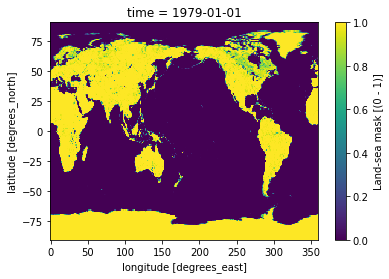

In [6]:
LSMask['lsm'].plot()

We can select all gridcelss where the land-sea mask values are > 0.5 in order to remove ocean gridcells:

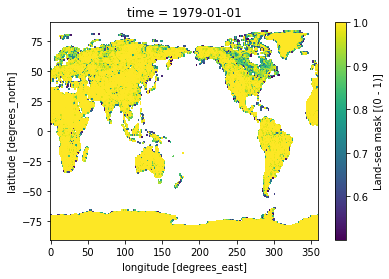

In [7]:
LSMask['lsm'].where(LSMask['lsm'] > 0.5).plot()

The longitude values in this dataset run from 0:360. We need to convert this to -180:180:

In [8]:
# convert the longitude from 0:360 to -180:180
LSMask['longitude'] = (((LSMask['longitude'] + 180) % 360) - 180)

## Calculating the anomaly

We want to show how anomalous the recorded monthly average temperature for 2020 is compared to the 1979-2010 average. 
We first calculate the temperature anomaly from the 1979-2010 mean and then calculate the standardardized anomaly by dividing the anomaly by the standard deviation: 

In [9]:
ERA5_anomaly = ERA5['t2m'] - ERA5['t2m'].sel(time=slice('1979','2010')).mean('time')
ERA5_anomaly.attrs = {
    'long_name': 'August temperature anomaly',
    'units': 'C'
}
ERA5_sd_anomaly = ERA5_anomaly / ERA5['t2m'].sel(time=slice('1979','2010')).std('time')
ERA5_sd_anomaly.attrs = {
    'long_name': 'August temperature standardized anomaly',
    'units': '-'
}

## Plotting the 2020 temperature anomaly

We define a function to plot the data on a global map:

In [10]:
def plot_California(ERA5_input):

    extent = [-120, -80, 20, 50]
    central_lon = np.mean(extent[:2])
    central_lat = np.mean(extent[2:])

    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    ax.set_extent(extent)

    ERA5_input.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        extend='both')

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.coastlines(
        resolution='110m')  #Currently can be one of “110m”, “50m”, and “10m”.
    ax.set_title('') 
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      draw_labels=True,
                      linewidth=1,
                      color='gray',
                      alpha=0.5,
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

And plot the ERA5 2020 temperature anomaly

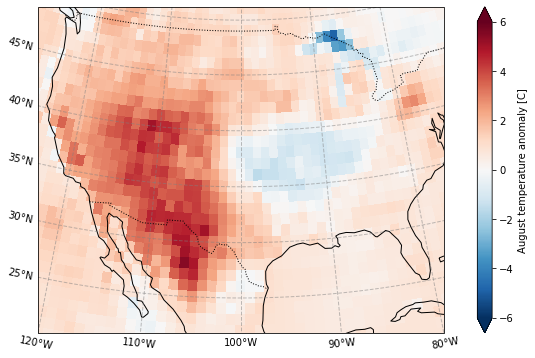

In [11]:
plot_California(ERA5_anomaly.sel(time = '2020'))
# plt.savefig('graphs/California_anomaly.png')

Plot the standardized anomaly

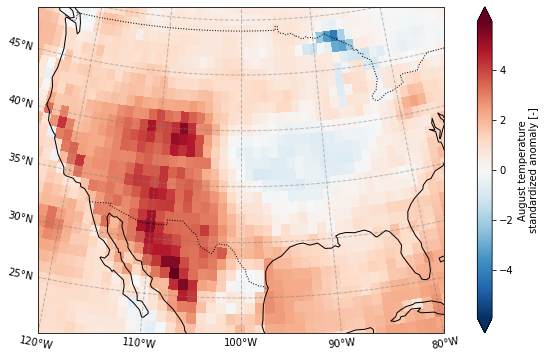

In [12]:
plot_California(ERA5_sd_anomaly.sel(time = '2020'))

## Selecting a domain for further analysis

We define the domain as a contiguous, land-only region within the box 125:100W,  20:45N with temperature anomalies above 2 standard deviation. 

In [17]:
ERA5_sd_anomaly_masked = (ERA5_sd_anomaly.
               sel(longitude = slice(-125,-100), #select the domain
                  latitude = slice(45,20)).      #select the domain
               where(ERA5_sd_anomaly.sel(time = '2020').squeeze('time')>2).  #Select the region where sd>2
               where(LSMask['lsm'].sel(time = '1979').squeeze('time') > 0.5) #Select land-only gridcells
              )
ERA5_sd_anomaly_masked.load()

<xarray.DataArray 't2m' (time: 42, latitude: 26, longitude: 26)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 45.0 44.0 43.0 42.0 ... 23.0 22.0 21.0 20.0
  * longitude  (longitude) float64 -125.0 -124.0 -123.0 ... -102.0 -101.0 -100.0
  * time       (time) datetime64[ns] 1979-08-01 1980-08-01 ... 2020-08-01
Attributes:
    long_name:  August temperature standardized anomaly
    units:      -

The resulting domain looks as follows:

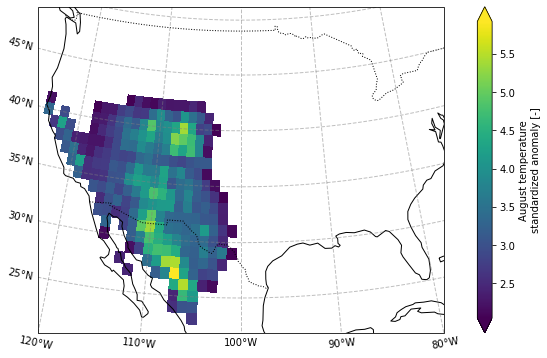

In [18]:
plot_California(ERA5_sd_anomaly_masked.sel(time = '2020'))

Let's make a nicer plot, using the previously defined function but adding an outline for the domain

In [21]:
def plot_California(ERA5_input, ERA5_masked):

    extent = [-120, -80, 20, 50]
    central_lon = np.mean(extent[:2])
    central_lat = np.mean(extent[2:])

    plt.figure(frameon=False, figsize=(90 / 25.4, 60 / 25.4))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    ax.set_extent(extent)

    ERA5_input.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        extend='both')
    
    (ERA5_masked.fillna(0).sel(time = '2020').
     squeeze('time').
        plot.contour(levels = [0],
                     colors = 'black',
                      transform=ccrs.PlateCarree(),
                      ax = ax)
    )

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.coastlines(
        resolution='110m')  #Currently can be one of “110m”, “50m”, and “10m”.
    ax.set_title('') 
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      draw_labels=True,
                      linewidth=1,
                      color='gray',
                      alpha=0.5,
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


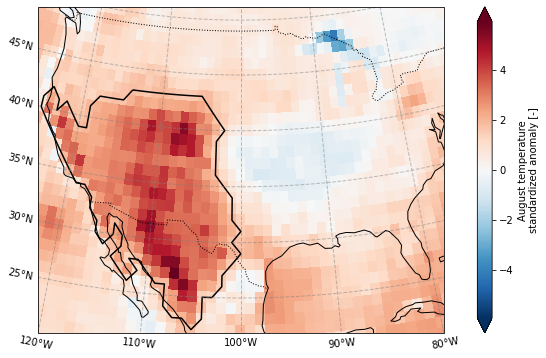

In [20]:
plot_California(ERA5_sd_anomaly.sel(time = '2020'),ERA5_sd_anomaly_masked)

Some functions that were used to create the figure for publication:
- Set figure size as 90 by 60mm and remove frame: `plt.figure(frameon=False, figsize=(90 / 25.4, 60 / 25.4))`
- Set the font: `plt.rcParams["font.family"] = "sans-serif"` 
- Set the font size: `plt.rcParams['font.size'] = 10`
- Set the font type so editing software (e.g. inkscape) can recognize text for svg graphics: `plt.rcParams['svg.fonttype'] = 'none'` 
- Same but for pdf files: `plt.rcParams['pdf.fonttype'] = 42` 

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


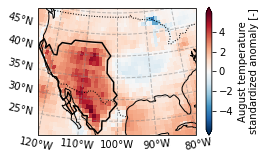

In [22]:
plt.rcParams["font.family"] = "sans-serif" ##change font
plt.rcParams['font.size'] = 10  ## change font size
# plt.rcParams['svg.fonttype'] = 'none' ## so inkscape recognized texts in svg file
plt.rcParams['pdf.fonttype'] = 42 ## so illustrator can recognize text
plot_California(ERA5_sd_anomaly.sel(time = '2020'),ERA5_sd_anomaly_masked)
plt.savefig('graphs/California_sd_anomaly_contour.pdf')

### Timeseries for the selected domain
Here we take the areal average over the selected domain and plot the resulting timeseries. Gridcell need to be weighted with their cell area when taking the spatial mean. We first calculate the area weights and then use these to average.  

In [23]:
area_weights = np.cos(np.deg2rad(ERA5_sd_anomaly.latitude))

ERA5_std_anomaly_timeseries = ERA5_sd_anomaly_masked.weighted(area_weights).mean(['longitude','latitude'])

<Figure size 255.118x170.079 with 0 Axes>

Text(0, 0.5, 'August standardized temperature anomaly')

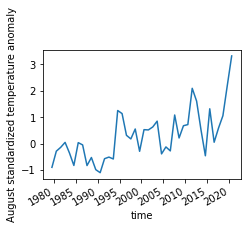

In [28]:
plt.figure(frameon=False, figsize=(90 / 25.4, 60 / 25.4))
ERA5_std_anomaly_timeseries.plot()
plt.ylabel('August standardized temperature anomaly')
plt.savefig('graphs/California_anomaly_timeseries.pdf')

Another option would be to use the Californian domain using regionmask: `states = regionmask.defined_regions.natural_earth.us_states_50`
